In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Cleaned-Updated-Keyword.csv')

In [3]:
df = df.drop(['Unnamed: 0.1','Unnamed: 0'], axis = 1)

In [4]:
# Define the categories you want to select
categories = ["People", "Arts", "History","Technology", "Mathematics", "Physical_sciences", "Biology_and_health_sciences", "Physical_sciences", "Everyday_life", "Geography", "Philosophy_and_religion", "Society_and_social_sciences"]

# Create an empty list to store the selected rows
selected_rows = []

# Loop through each category and select 100 rows
for category in categories:
    category_rows = df[df["Category"] == category].head(100)
    selected_rows.append(category_rows)

# Concatenate all the selected rows into a new dataframe
df = pd.concat(selected_rows)

In [5]:
df = df[['Article', 'Category']]

In [6]:
df.shape

(1200, 2)

In [7]:
df.index = range(df.shape[0])
df['Article'].apply(lambda x: len(x.split(' '))).sum()

8513514

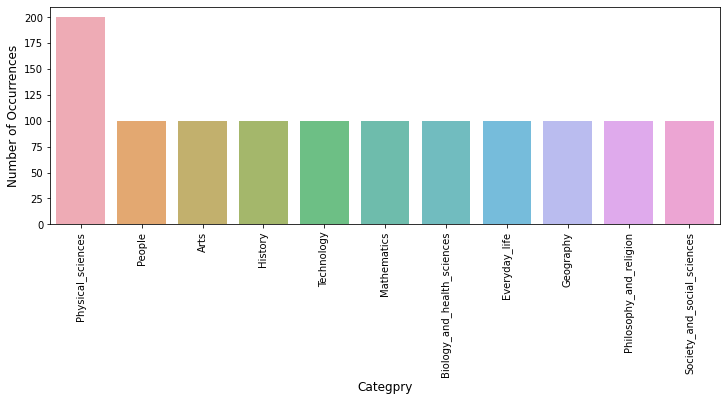

In [8]:
cnt_pro = df['Category'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Categpry', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [9]:
train, test = train_test_split(df, test_size = 0.3, random_state = 42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 3:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Article']), tags=[r.Category]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Article']), tags=[r.Category]), axis=1)

In [10]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [11]:
model_dbow = Doc2Vec(dm = 0, vector_size = 300, negative = 5, hs = 0, min_count = 2, sample = 0, workers = cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 840/840 [00:00<00:00, 1749362.14it/s]


In [12]:
%%time
for epoch in range(50):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples = len(train_tagged.values), epochs = 1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 840/840 [00:00<00:00, 2133988.71it/s]


CPU times: user 9min 5s, sys: 2.31 s, total: 9min 8s
Wall time: 1min 42s


In [13]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps = 50)) for doc in sents])
    return targets, regressors

In [14]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
logreg = LogisticRegression(multi_class='multinomial', solver='newton-cg', max_iter = 10000, n_jobs = -1, C = 1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.11666666666666667
Testing F1 score: 0.11769821860602635


In [25]:
model_dmm = Doc2Vec(dm = 1, dm_mean = 1, vector_size = 300, window = 10, negative = 5, min_count = 1, workers = 5, alpha = 0.065, min_alpha = 0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 840/840 [00:00<00:00, 1073823.64it/s]


In [26]:
%%time
for epoch in range(50):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 840/840 [00:00<00:00, 1169726.22it/s]


CPU times: user 11min 51s, sys: 12.2 s, total: 12min 3s
Wall time: 4min 6s


In [27]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average = 'weighted')))

Testing accuracy 0.75
Testing F1 score: 0.7431100815185864


In [28]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors = True, keep_inference = True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors = True, keep_inference = True)

In [29]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [30]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps = 50)) for doc in sents])
    return targets, regressors

In [31]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [32]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average = 'weighted')))

Testing accuracy 0.7527777777777778
Testing F1 score: 0.747256858215427
